# prepared required lib

### install required lib

In [1]:
!pip install tensorflowjs --quiet
!pip install tensorflow --quiet
!pip install seaborn --quiet
!pip install matplotlib --quiet
!pip install kaggle --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 22.4 MB/s eta 0:00:00


### import required lib

In [2]:
import zipfile
import os
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, save_img, array_to_img
from numpy import expand_dims
from PIL import Image
import pandas as pd
import random
import shutil
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import Sequence
import pathlib

# Data Collection

### dataset download & extract

In [3]:
!kaggle datasets download -d alessiocorrado99/animals10 --quiet

Dataset URL: https://www.kaggle.com/datasets/alessiocorrado99/animals10
License(s): GPL-2.0


In [4]:
zip_file_path = 'animals10.zip'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall()

os.remove(zip_file_path)

### rename folders category

In [5]:
from translate import translate

dataset_dir = 'raw-img'

for folder_name in os.listdir(dataset_dir):
    folder_path = os.path.join(dataset_dir, folder_name)

    if os.path.isdir(folder_path):
        new_folder_name = translate.get(folder_name, None)

        if new_folder_name:
            new_folder_path = os.path.join(dataset_dir, new_folder_name)

            shutil.move(folder_path, new_folder_path)

### keep 3 categories

In [6]:
dataset_path = "raw-img"

all_folders = os.listdir(dataset_path)

folders_to_keep = random.sample(all_folders, 3)

for folder in all_folders:
    folder_path = os.path.join(dataset_path, folder)

    if os.path.isdir(folder_path) and folder not in folders_to_keep:
        shutil.rmtree(folder_path)

        print(f"Deleted folder: {folder}")

Deleted folder: cat
Deleted folder: sheep
Deleted folder: horse
Deleted folder: elephant
Deleted folder: squirrel
Deleted folder: butterfly
Deleted folder: dog


### count all image in each category folders

In [7]:
def plot_bar(x_category, y_count):

    data_barplot = {
        'Category': x_category,
        'Count': y_count
    }

    sns.barplot(x='Category', y='Count', data=data_barplot)

    plt.xticks(rotation=45)

    plt.show()

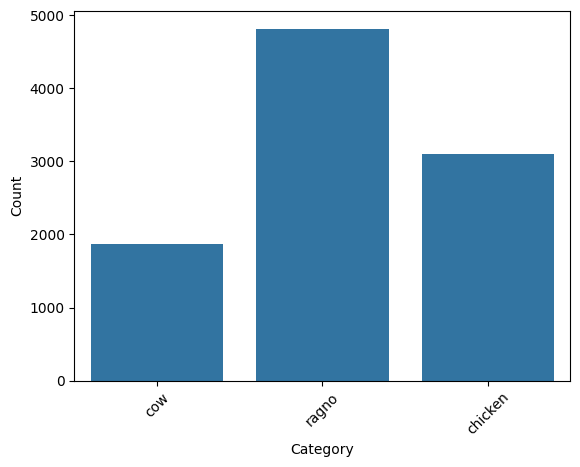

In [8]:
x_category = []
old_y_count = []

data_dir = 'raw-img'
list_dir = os.listdir(data_dir)

for category in list_dir:
    path_category = os.path.join(data_dir, category)
    count = len(os.listdir(path_category))

    x_category.append(category)
    old_y_count.append(count)

plot_bar(x_category, old_y_count)

Due to the imbalance in the amount of data per category, image augmentation will be performed to generate new data so that the number of data in each category becomes balanced.

# data preprocessing (augmented imbalance)

In [9]:
generate_new_img_datagen = ImageDataGenerator(
    rotation_range=30,
    shear_range=0.3,
    zoom_range=0.3,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [10]:
TARGET_SIZE = (256, 256)

def load_and_augment_image(file_path):
    img = load_img(file_path, target_size=TARGET_SIZE)
    img_array = img_to_array(img)
    img_array = expand_dims(img_array, 0)
    augmented_iter = generate_new_img_datagen.flow(img_array, batch_size=1)
    augmented_img = next(augmented_iter)[0]
    return augmented_img

def save_image(img_array, save_path):
    img = array_to_img(img_array)
    img.save(save_path)

def augment_images_in_folder(category, folder_path, target_count):
    image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
    current_count = len(image_files)

    if current_count < target_count:
        print(f"Augmenting '{category}' from {current_count} to {target_count} images.")

        augmented_images_needed = target_count - current_count

        for i in range(augmented_images_needed):
            img_path = random.choice(image_files)
            augmented_img = load_and_augment_image(img_path)
            save_path = os.path.join(OUTPUT_DIR, category, f"augmented_{i + current_count}.jpg")
            save_image(augmented_img, save_path)

    for i, img_path in enumerate(image_files):
        original_save_path = os.path.join(OUTPUT_DIR, category, f"original_{i}.jpg")

        if not os.path.exists(original_save_path):
            shutil.copy(img_path, original_save_path)


def process_dataset(base_dir, output_dir):
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)

    os.makedirs(output_dir)

    categories = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

    max_count = max(len(os.listdir(os.path.join(base_dir, category)))for category in categories)

    for category in categories:
        category_path = os.path.join(base_dir, category)
        target_folder = os.path.join(output_dir, category)
        os.makedirs(target_folder, exist_ok=True)

        current_count = len([f for f in os.listdir(category_path) if f.endswith(('.jpg', '.jpeg', '.png'))])

        print(f"Processing category '{category}' with {current_count} images...")

        augment_images_in_folder(category, category_path, max_count)

In [11]:
dataset_dir = 'raw-img'
OUTPUT_DIR = 'augmented_images'

process_dataset(dataset_dir, OUTPUT_DIR)

Processing category 'cow' with 1866 images...
Augmenting 'cow' from 1866 to 4821 images.
Processing category 'ragno' with 4821 images...
Processing category 'chicken' with 3098 images...
Augmenting 'chicken' from 3098 to 4821 images.


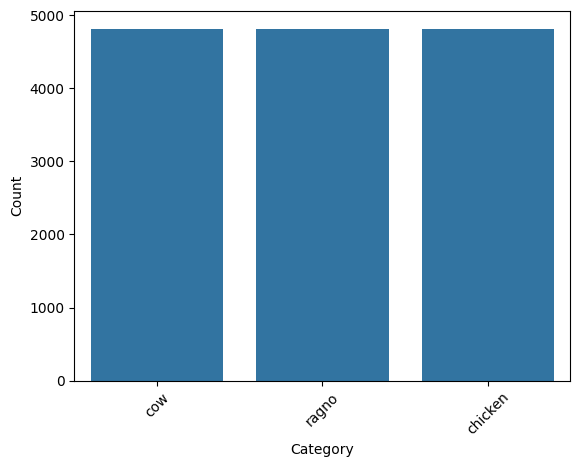

In [12]:
new_y_count = []

aug_dir = 'augmented_images'
list_dir = os.listdir(aug_dir)

for category in list_dir:
    path_category = os.path.join(aug_dir, category)
    count = len(os.listdir(path_category))

    new_y_count.append(count)

plot_bar(x_category, new_y_count)

### show img sample each category

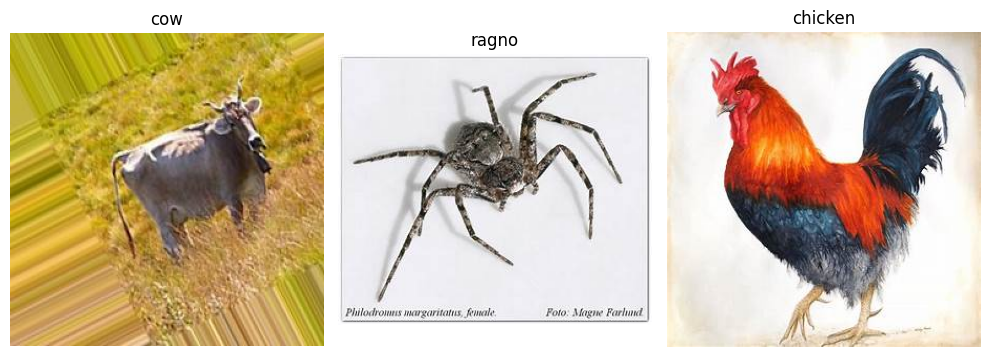

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(10, 6))
axes = axes.ravel()

for i, category in enumerate(x_category):
    folder_path = os.path.join(aug_dir, category)

    image_file = random.choice(os.listdir(folder_path))
    image_path = os.path.join(folder_path, image_file)

    img = Image.open(image_path)

    axes[i].imshow(img)
    axes[i].set_title(category)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# model training (CNN)

### data splitting

In [14]:
def split_dataset(augmented_dir, train_dir, test_dir, split_ratio=0.8):
    if os.path.exists(train_dir):
        shutil.rmtree(train_dir)

    if os.path.exists(test_dir):
        shutil.rmtree(test_dir)

    os.makedirs(train_dir)
    os.makedirs(test_dir)

    categories = [d for d in os.listdir(augmented_dir) if os.path.isdir(os.path.join(augmented_dir, d))]

    for category in categories:
        category_path = os.path.join(augmented_dir, category)
        images = [f for f in os.listdir(category_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
        random.shuffle(images)

        split_point = int(len(images) * split_ratio)

        os.makedirs(os.path.join(train_dir, category), exist_ok=True)
        os.makedirs(os.path.join(test_dir, category), exist_ok=True)

        for img in images[:split_point]:
            shutil.copy(os.path.join(category_path, img),
                        os.path.join(train_dir, category, img))

        for img in images[split_point:]:
            shutil.copy(os.path.join(category_path, img),
                        os.path.join(test_dir, category, img))

In [15]:
augmented_dir = 'augmented_images'
train_dir = 'split/train'
test_dir = 'split/test'

split_dataset(augmented_dir, train_dir, test_dir, 0.8)

### remove unnecessary files

In [16]:
!rm -rf augmented_images/ raw-img/ translate.py sample_data/

### load train & test dataset

In [23]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    shear_range=0.3,
    zoom_range=0.3,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(100, 100),
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(100, 100),
    class_mode='categorical'
)

Found 11568 images belonging to 3 classes.
Found 2895 images belonging to 3 classes.


### model defining

In [26]:
def create_cnn_model(input_shape=(100, 100, 3), num_classes=10):
    model = Sequential([
        Input(shape=input_shape),

        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.2),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.2),

        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.2),

        Flatten(),
        Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
        Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
        Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.5),
        Dense(3, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

### early stopping & checkpoint

In [19]:
class CustomEarlyStopping(Callback):
    def __init__(self, target_accuracy=0.85):
        super(CustomEarlyStopping, self).__init__()
        self.target_accuracy = target_accuracy

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        train_acc = logs.get('accuracy')
        val_acc = logs.get('val_accuracy')

        if train_acc is not None and val_acc is not None:
            if train_acc >= self.target_accuracy and val_acc >= self.target_accuracy:
                print(
                    f"\nTraining and validation accuracies reached {self.target_accuracy*100}% - stopping training.")
                self.model.stop_training = True


early_stopping_callback = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    'best_model.keras', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

### training model

In [27]:
input_shape = (100, 100, 3)
num_classes = len(train_generator.class_indices)

model = create_cnn_model(input_shape=input_shape, num_classes=num_classes)

custom_early_stopping_callback = CustomEarlyStopping(target_accuracy=0.86)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    epochs=32,
    callbacks=[early_stopping_callback,
               custom_early_stopping_callback, checkpoint],
    shuffle=True,
    verbose=1
)

Epoch 1/32
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 729ms/step - accuracy: 0.3977 - loss: 1.3814
Epoch 1: val_accuracy improved from 0.33437 to 0.53368, saving model to best_model.keras
361/361 ━━━━━━━━━━━━━━━━━━━━ 285s 775ms/step - accuracy: 0.3979 - loss: 1.3809 - val_accuracy: 0.5337 - val_loss: 1.0124
Epoch 2/32
  1/361 ━━━━━━━━━━━━━━━━━━━━ 3:02 507ms/step - accuracy: 0.4062 - loss: 1.0048
Epoch 2: val_accuracy improved from 0.53368 to 0.73333, saving model to best_model.keras
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 647us/step - accuracy: 0.4062 - loss: 1.0048 - val_accuracy: 0.7333 - val_loss: 0.8458
Epoch 3/32
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 724ms/step - accuracy: 0.5589 - loss: 0.9843
Epoch 3: val_accuracy did not improve from 0.73333
361/361 ━━━━━━━━━━━━━━━━━━━━ 278s 769ms/step - accuracy: 0.5589 - loss: 0.9842 - val_accuracy: 0.6663 - val_loss: 0.8596
Epoch 4/32
  1/361 ━━━━━━━━━━━━━━━━━━━━ 3:22 562ms/step - accuracy: 0.7500 - loss: 0.8515
Epoch 4: val_accuracy did not improve from 0.73333
361

# model evaluation

### model accuracy plot

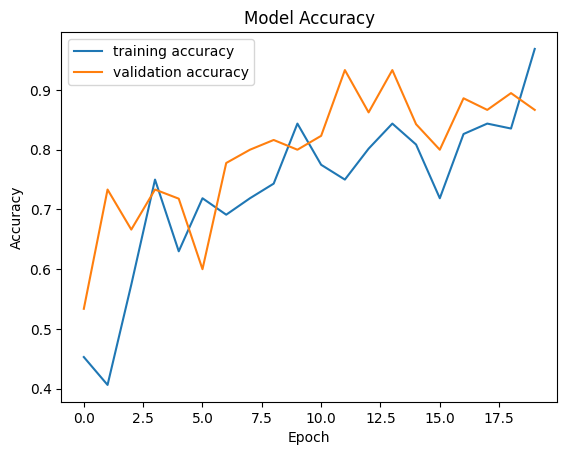

In [28]:
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

### model loss plot

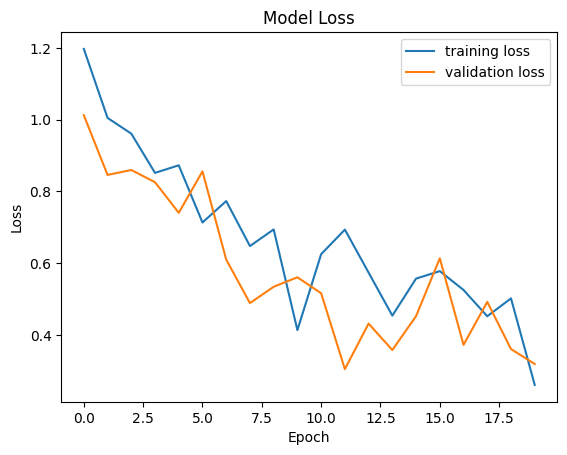

In [29]:
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# convert model

In [30]:
export_dir = 'saved_model/'

### SavedModel

In [31]:
tf.saved_model.save(model, export_dir)

# for tfjs conversion from .h5 format
model.save('model.h5')

### TFJS

In [32]:
TF_ENABLE_ONEDNN_OPTS = 0

In [33]:
!tensorflowjs_converter \
    --input_format=keras \
    model.h5 \
    tfjs_model

2024-10-20 08:31:16.659428: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-20 08:31:16.682593: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-20 08:31:16.689464: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-20 08:31:17.975444: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
failed to lookup keras version from the file,
    this is likely a weight only file


### TFLite

In [34]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

os.makedirs('tflite_model', exist_ok=True)

with open('tflite_model/model.tflite', 'wb') as f:
    f.write(tflite_model)


Saved artifact at '/tmp/tmpcu3thv3o'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name='keras_tensor_34')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  132145353588800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132145353591264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132145353593024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132145353601472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132145353600768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132145353603584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132145353593200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132145353602000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132145353600944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132145353600416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13214518419

# generate requirements.txt

In [35]:
!pip freeze > requirements.txt

# download colab resources to local

In [40]:
from google.colab import files

!zip -r saved_model.zip saved_model/
!zip -r tfjs_model.zip tfjs_model/
!zip -r tflite_model.zip tflite_model/

files.download('saved_model.zip')
files.download('tfjs_model.zip')
files.download('tflite_model.zip')

files.download('best_model.keras')
files.download('model.h5')
files.download('requirements.txt')


updating: saved_model/ (stored 0%)
updating: saved_model/assets/ (stored 0%)
updating: saved_model/saved_model.pb (deflated 88%)
updating: saved_model/fingerprint.pb (stored 0%)
updating: saved_model/variables/ (stored 0%)
updating: saved_model/variables/variables.index (deflated 65%)
updating: saved_model/variables/variables.data-00000-of-00001 (deflated 5%)
updating: tfjs_model/ (stored 0%)
updating: tfjs_model/model.json (deflated 88%)
updating: tfjs_model/group1-shard2of2.bin (deflated 4%)
updating: tfjs_model/group1-shard1of2.bin (deflated 5%)
updating: tflite_model/ (stored 0%)
updating: tflite_model/model.tflite (deflated 5%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>